In [1]:
import os,time,sys
import matplotlib.pyplot as plt 
import numpy as np
from charon import propa
from charon import profile
import charon.physicsconstants as PC
pc = PC.PhysicsConstants()
from Spectra_functions import Spectra_generator, Spectra_interpolation, Flux_generator, J_interpolation, Flux_interpolation, Signal_PDF, Background_PDF
from LikelihoodFunctions import ts_llhinterval, UpperLimit
from ipynb.fs.full.func_plot_histo import plot_projections
from scipy.interpolate import interp1d
import random as rd

In [2]:
sys.path.append("/home/dvaldenaire/Python/Analysis/DMfit/DMfit")
from modeling import PdfBase, Model, Parameter
from data_DM import DataSet
from llh import LikelihoodRatioTest

Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5


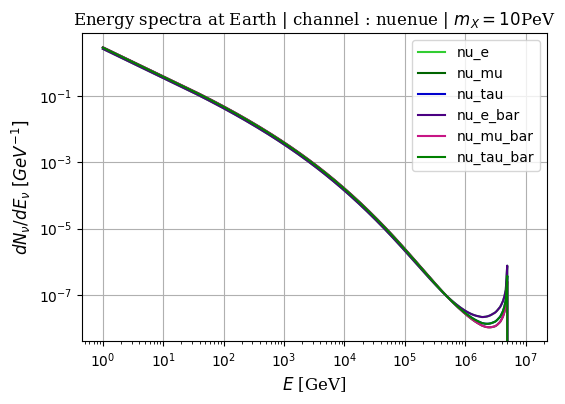

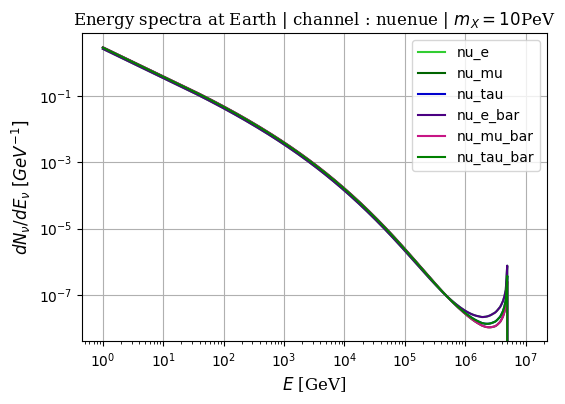

In [3]:
Reco_rate_nue_NFW = Signal_PDF(mass=1e7, channel='nuenue',process='decay',galactic_profile=profile.NFW, extrapolation=True, normalize=True)
Reco_rate_nue_Burkert = Signal_PDF(mass=1e7, channel='nuenue',process='decay',galactic_profile=profile.Burkert,extrapolation=True, normalize=True)

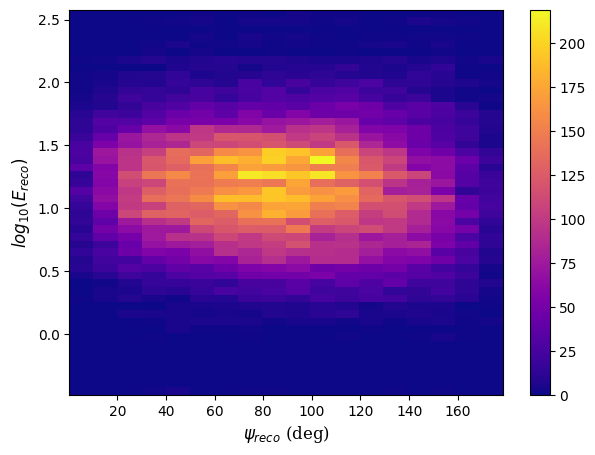

In [4]:
Background = Background_PDF(oversample=True, hist=True, bins=[18,50], density=False)

In [5]:
# PDFs:
SignalPDF = PdfBase(Reco_rate_nue_NFW.flatten()/np.sum(Reco_rate_nue_NFW), name='Signal PDF')
BackgroundPDF = PdfBase((Background[0].flatten())/np.sum(Background[0]), name='Background PDF')

In [6]:
# PARAMETERS:
ParameterH1 = Parameter(value=0.5, limits=(0,1), fixed=False, name='H1')
ParameterH0 = Parameter(value=0., limits=(0,1), fixed=True, name='H0')

In [7]:
# HYPOTHESES:
modelH1 = ParameterH1*SignalPDF + (1-ParameterH1)*BackgroundPDF
modelH0 = ParameterH0*SignalPDF + (1-ParameterH0)*BackgroundPDF

Parameter H1 already exists in the model, it won't be added again
Parameter H0 already exists in the model, it won't be added again


In [8]:
ds = DataSet()
Background_sample = Background_PDF(oversample=True, hist=False, bins=None, density=None)
ds.sample(np.sum(Background_sample), modelH1) #define sample

In [9]:
lr = LikelihoodRatioTest(model = modelH1, null_model = modelH0) #define likelihood
lr.data = ds #inject data in the likelihood model

In [10]:
lr.fit("H1")
lr.fit("H0")
lr.TS

/home/dvaldenaire/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/dvaldenaire/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


18444.504705498868

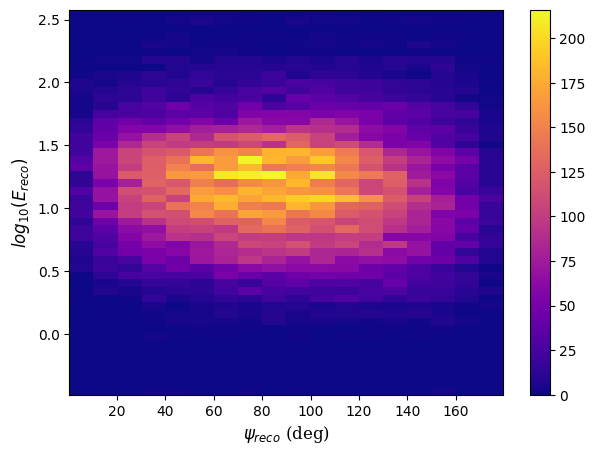

In [11]:
PseudoData = Background_PDF(oversample=True, hist=True, bins=[18,50], density=False) # no signal

In [12]:
#SignalPDF and Background fixed but poisson for Data ?
Sigma = UpperLimit(Reco_rate_nue_NFW, Background, PseudoData)

Parameter fit already exists in the model, it won't be added again
Parameter fix already exists in the model, it won't be added again
Parameter inj already exists in the model, it won't be added again
signal fraction: 0.024751026738635145
TS value at the output upper limit: 1.6399995508836582


In [13]:
def BackgroundPoisson():
    Background = Background_PDF(oversample=True, hist=True, bins=[18,50], density=False)
    return np.random.poisson(Background[0])

In [32]:
def Sensitivity(channel,process,galactic_profile):
    Sigma = []
    mass_range = np.logspace(6,12,7) #define mass range between 1PeV(10⁶ GeV) and 1 ZeV (10^12 GeV)
    Background = Background_PDF(oversample=True, hist=True, bins=[18,50], density=False)
    Background_sample = Background_PDF(oversample=True, hist=False, bins=None, density=None)
    for mass in mass_range:
        # PARAMETERS:
        RecoRate = Signal_PDF(mass=mass, channel=channel,process=process,galactic_profile=galactic_profile, extrapolation=True, normalize=True)
        ParameterH1 = Parameter(value=0.5, limits=(0,1), fixed=False, name='H1')
        ParameterH0 = Parameter(value=0., limits=(0,1), fixed=True, name='H0')
        # PDFs:
        SignalPDF = PdfBase(RecoRate.flatten()/np.sum(Reco_rate_nue_NFW), name='Signal PDF')
        BackgroundPDF = PdfBase((Background[0].flatten())/np.sum(Background[0]), name='Background PDF')
        PseudoData = Background_PDF(oversample=True, hist=True, bins=[18,50], density=False)
        # HYPOTHESES:
        modelH1 = ParameterH1*SignalPDF + (1-ParameterH1)*BackgroundPDF
        modelH0 = ParameterH0*SignalPDF + (1-ParameterH0)*BackgroundPDF
        #DATA SET:
        ds = DataSet()
        ds.sample(np.sum(Background_sample), modelH1)
        #LIKELIHOOD:
        lr = LikelihoodRatioTest(model = modelH1, null_model = modelH0)
        lr.data = ds
        lr.fit("H1")
        lr.fit("H0")
        lr.TS
        #SENSITIVITY:
        Sigma.append(UpperLimit(Reco_rate_nue_NFW, Background, PseudoData))
    return Sigma

Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Parameter H1 already exists in the model, it won't be added again
Parameter H0 already exists in the model, it won't be added again
Parameter fit already exists in the model, it won't be added again
Parameter fix already exists in the model, it won't be added again
Parameter inj already exists in the model, it won't be added again
signal fraction: 0.025213716657439787
TS value at the output upper limit: 1.639999460807303
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Fl

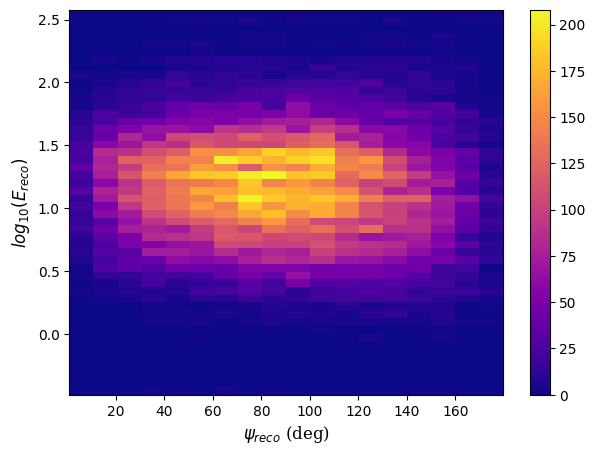

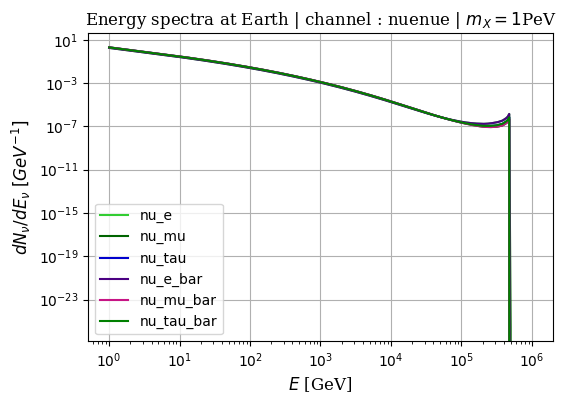

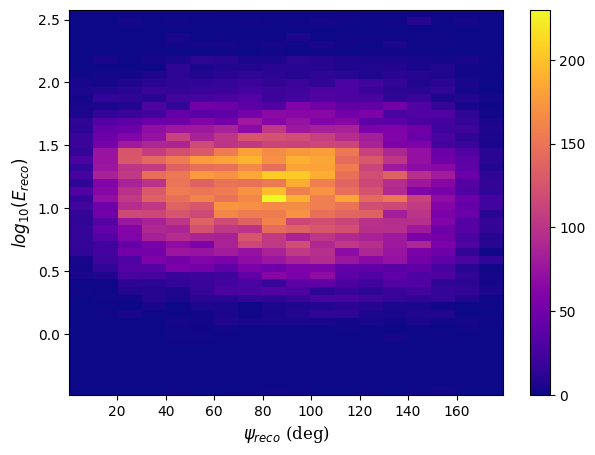

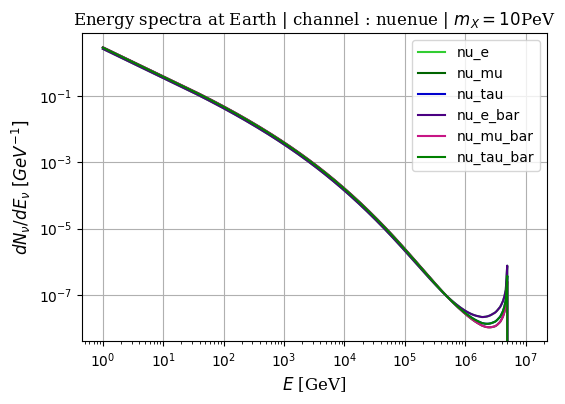

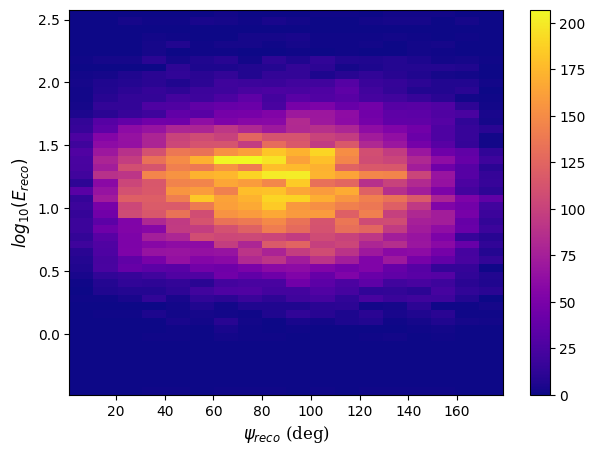

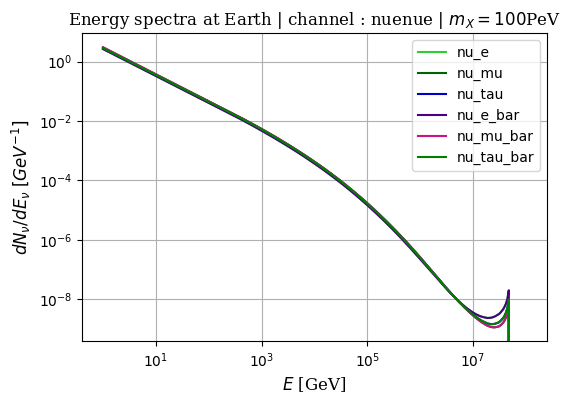

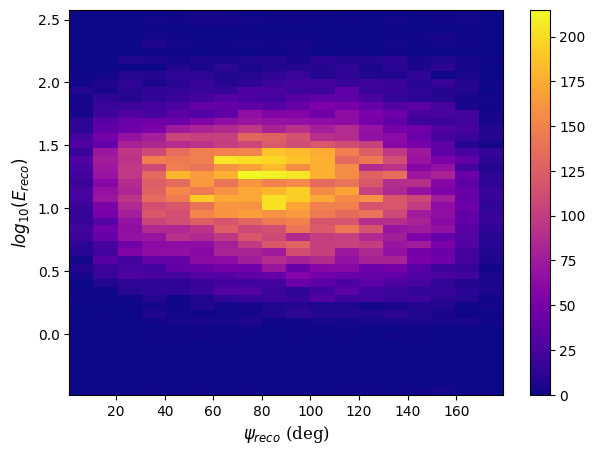

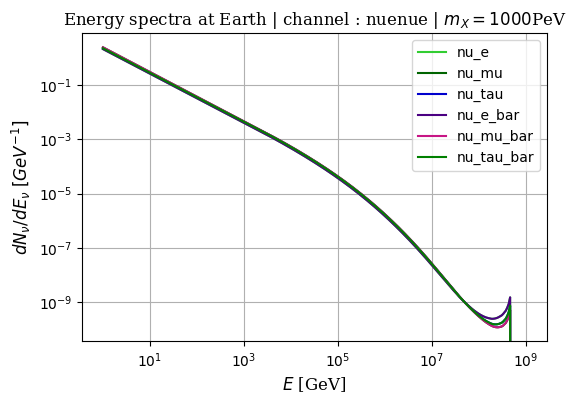

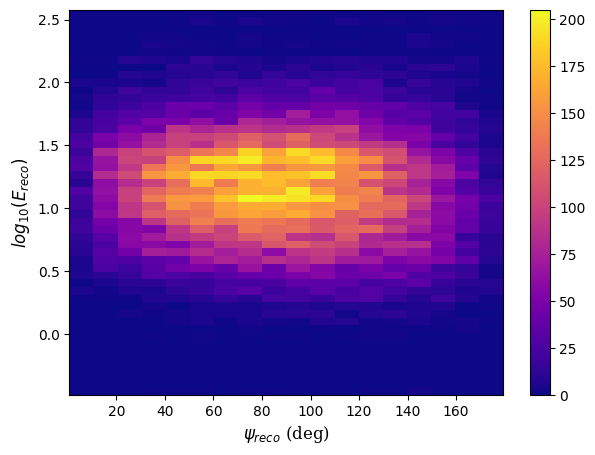

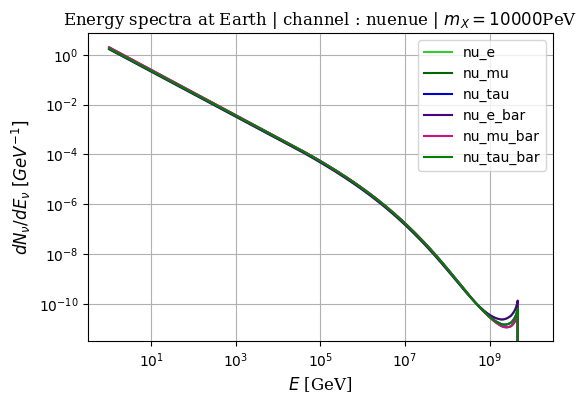

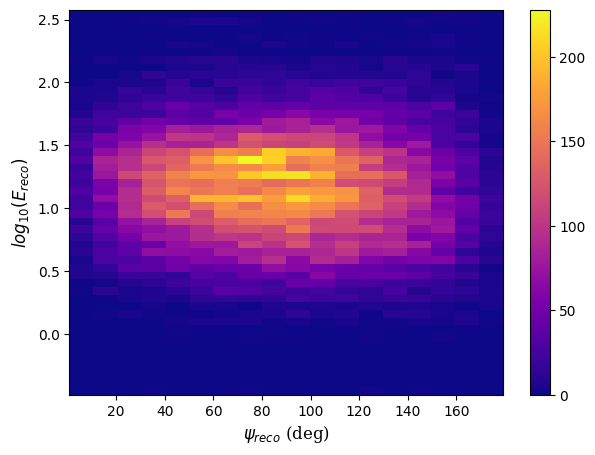

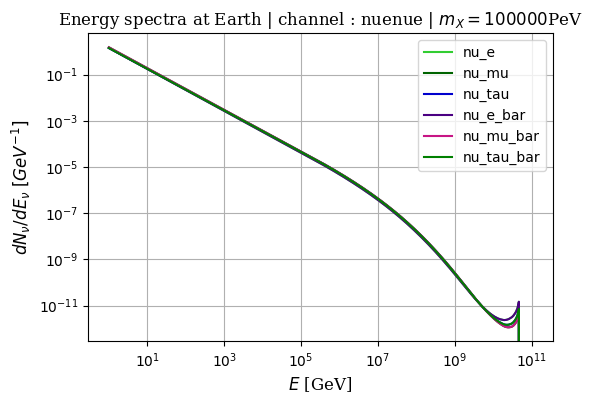

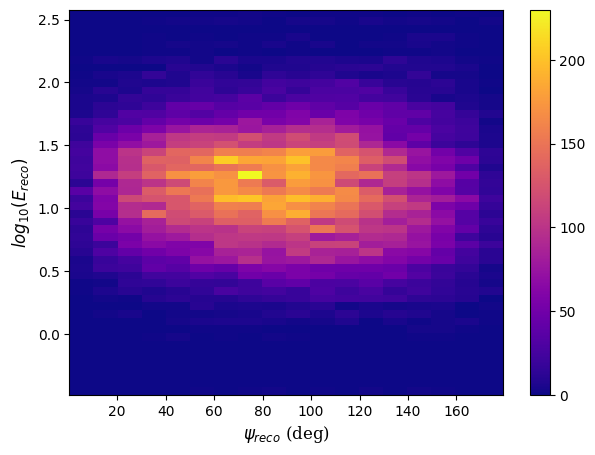

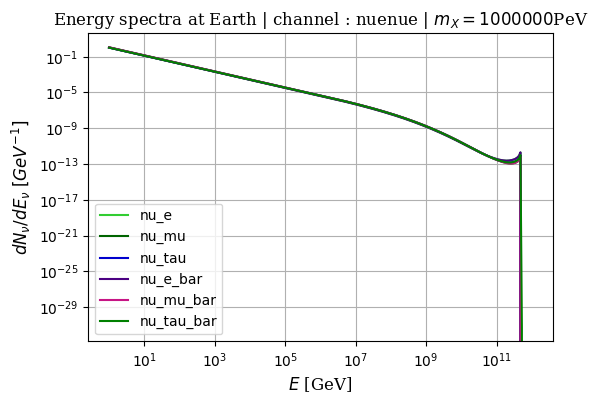

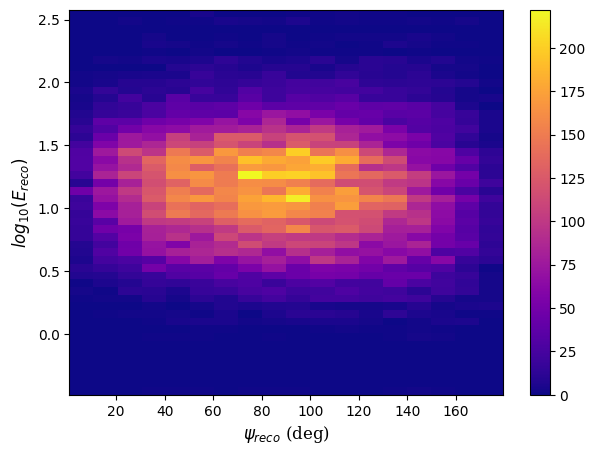

In [33]:
Sigma = Sensitivity(channel='nuenue', process='decay', galactic_profile=profile.NFW)

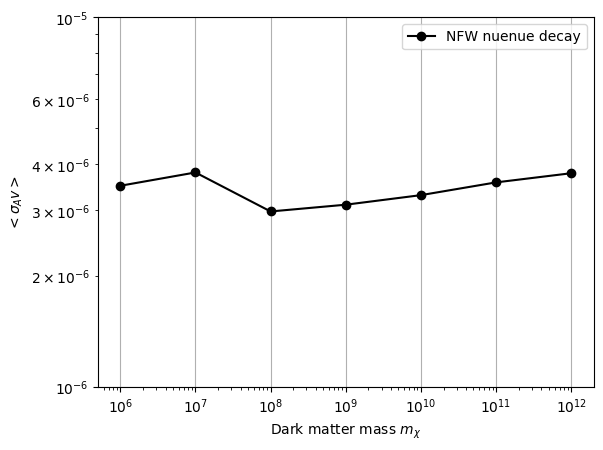

In [39]:
mass_range = np.logspace(6,12,7)
plt.plot(mass_range, Sigma, 'ko-' ,label='NFW nuenue decay')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-6, 1e-5)
plt.xlabel(r'Dark matter mass $m_\chi$')
plt.ylabel(r'$<\sigma_A v>$')
plt.grid()
plt.legend()

In [31]:
np.logspace(6,12,7)

array([1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10, 1.e+11, 1.e+12])